In [38]:
import tensorflow as tf
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import gc

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import tensorflow.keras.utils as data

In [39]:

with open("C:/Users/pbang/Downloads/archive (1)/train/_annotations.coco.json") as f:
    coco_data_train = json.load(f)

images_train = coco_data_train['images']
annotations_train = coco_data_train['annotations']
categories_train = coco_data_train['categories']


In [40]:
with open("C:/Users/pbang/Downloads/archive (1)/valid/_annotations.coco.json") as f:
    coco_data_val = json.load(f)

images_val = coco_data_val['images']
annotations_val = coco_data_val['annotations']
categories_val= coco_data_val['categories']

In [41]:
annotations_val[0]['image_id']

0

In [42]:
images_path_train_list = ["C:/Users/pbang/Downloads/archive (1)/train/" + i['file_name'] for i in images_train]
images_path_val_list = ["C:/Users/pbang/Downloads/archive (1)/valid/" + i['file_name'] for i in images_val]


In [43]:
import cv2
import numpy as np

# Giả sử img_info chứa thông tin của ảnh hiện tại
height, width = 640, 640

def create_mask(annotations, save_path):
  # Lấy tất cả annotation của ảnh có id = image_id
  for ann in annotations:
    mask = np.zeros((height, width), dtype=np.uint8)
          # Lấy thông tin bbox và segmentation
    polygons = np.array(ann['segmentation'][0]).reshape((-1, 2)).astype(np.int32)

    # Vẽ vùng segmentation lên ảnh gốc
    cv2.fillPoly(mask, [polygons], color=1)  # Màu xanh lá cho khối u
    path = save_path + str(ann['image_id']) + ".png"
    # Thêm vào danh sách kết quả
    cv2.imwrite(path, mask)
    print(f"Saved mask {ann['image_id']} to {path}")

In [44]:
# train_mask_path = 'C:/Users/pbang/Downloads/archive (1)/train_mask/'
# val_mask_path = 'C:/Users/pbang/Downloads/archive (1)/val_mask/'
# mask_train_list = create_mask(annotations_train, train_mask_path)
# mask_val_list = create_mask(annotations_val, val_mask_path)

In [45]:
mask_path_train_list = ["C:/Users/pbang/Downloads/archive (1)/train_mask/" + str(i['image_id']) + '.png' for i in annotations_train]
mask_path_val_list = ["C:/Users/pbang/Downloads/archive (1)/val_mask/" + str(i['image_id']) + '.png' for i in annotations_val]

In [46]:
# Chọn một ảnh bất kỳ từ mỗi tập
def draw(train_image_path, train_mask_path, pre_img_mask):
# Đọc ảnh bằng OpenCV (BGR -> RGB)
    train_image = cv2.imread(train_image_path)
    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)

    # Đọc ảnh bằng OpenCV (BGR -> RGB)
    mask_image = cv2.imread(train_mask_path)
    print(mask_image.shape)
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
    mask_image = mask_image * 255

    # print(pre_img_mask)
    pre_mask = cv2.cvtColor(pre_img_mask, cv2.COLOR_BGR2RGB)
    pre_mask = pre_mask * 255
    # print(pre_mask)
    # Vẽ ảnh
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(train_image)
    axes[0].set_title("Train Image")
    axes[0].axis("off")

    axes[1].imshow(mask_image)
    axes[1].set_title("Validation Image")
    axes[1].axis("off")

    axes[2].imshow(pre_mask)
    axes[2].set_title("Predict Mask")
    axes[2].axis("off")
    plt.show()


In [47]:
class Mydataset():
  def __init__(self, imgs_path, mask_path, w, h):
    self.imgs_path = imgs_path
    self.mask_path = mask_path
    self.w = w
    self.h = h
  def __len__(self):
    return len(self.imgs_path)
  def __getitem__(self, idx):
    img = cv2.imread(self.imgs_path[idx])
    img = cv2.resize(img, (self.w, self.h), interpolation = cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    # # Chuẩn hóa theo ImageNet (trừ mean, chia std)
    # imagenet_mean = np.array([0.485, 0.456, 0.406])  # Giá trị mean của ImageNet
    # imagenet_std = np.array([0.229, 0.224, 0.225])   # Giá trị std của ImageNet
    # img = (img - imagenet_mean) / imagenet_std  # Chuẩn hóa ảnh

    mask = cv2.imread(self.mask_path[idx], cv2.IMREAD_UNCHANGED)
    img_mask = cv2.resize(mask, (self.w, self.h), interpolation = cv2.INTER_AREA)

    img_mask = [(img_mask == v) for v in [1]]
    img_mask = np.stack(img_mask, axis=-1).astype('float')
    return img, img_mask

In [48]:
train_dataset = Mydataset(images_path_train_list, mask_path_train_list, 256, 256)
val_dataset = Mydataset(images_path_val_list, mask_path_val_list, 256, 256)

In [49]:
train_dataset.__getitem__(0)[1]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [50]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.dataset[i] for i in batch_indexes]

        # Chuyển danh sách thành numpy array theo từng đặc trưng
        batch = [np.stack(samples, axis=0) for samples in zip(*batch_data)]

        return tuple(batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [51]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

In [52]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):


    conv = Conv2D(n_filters, 
                  (3,3),   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  (3,3),   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(rate = dropout_prob)(conv)


    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [53]:
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    
                 (3,3),    
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   
                 (3,3),     
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  
                 (3,3),   
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [54]:
# GRADED FUNCTION: unet_model
def unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=1):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2 * n_filters)
    cblock3 = conv_block(cblock2[0], 2*2* n_filters)
    cblock4 = conv_block(cblock3[0], 2*2*2* n_filters, dropout_prob=0.1) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2*2*2*2* n_filters, dropout_prob=0.1, max_pooling=False)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  4* n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2 * n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, kernel_size = 1,activation='sigmoid', padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [55]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [56]:
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_20[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_24[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_26[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_27[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_28[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_29[0][0] 

 Total params: 8,639,745 (32.96 MB)

 Trainable params: 8,639,745 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

In [58]:
unet.compile(optimizer='adam',
              loss=combined_loss,
              metrics=['accuracy'])

In [59]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [60]:
EPOCHS = 5
model_history = unet.fit(train_dataloader, epochs=EPOCHS, validation_data=val_dataloader)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - accuracy: 0.9449 - loss: 0.6674 - val_accuracy: 0.9628 - val_loss: 0.5263
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.9388 - loss: 0.5246 - val_accuracy: 0.8712 - val_loss: 0.5464
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.8951 - loss: 0.5209 - val_accuracy: 0.9186 - val_loss: 0.5015
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 505s 5s/step - accuracy: 0.9193 - loss: 0.4949 - val_accuracy: 0.9317 - val_loss: 0.4937
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 525s 6s/step - accuracy: 0.9305 - loss: 0.4897 - val_accuracy: 0.9512 - val_loss: 0.4745


In [61]:
save_path = "C:/Users/pbang/Downloads/archive (1)/unet_model.h5"  # Đường dẫn cụ thể
unet.save(save_path)

In [62]:
from tensorflow.keras.models import load_model

# Đường dẫn đến model đã lưu
model_path = "C:/Users/pbang/Downloads/archive (1)/unet_model.h5"

# Tải lại model
model = load_model(model_path, compile=False)
print("Model loaded successfully!")


Model loaded successfully!


In [65]:
def predict(imgs_path, mask_path, w, h):
    img = cv2.imread(imgs_path)
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    # Chuẩn hóa theo ImageNet (trừ mean, chia std)
    imagenet_mean = np.array([0.485, 0.456, 0.406])  # Giá trị mean của ImageNet
    imagenet_std = np.array([0.229, 0.224, 0.225])   # Giá trị std của ImageNet
    img = (img - imagenet_mean) / imagenet_std  # Chuẩn hóa ảnh
    img = np.expand_dims(img, axis=0)  # Thêm batch_size=1 -> shape thành (1, 128, 128, 3)
    pred_mask = model.predict(img)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    pred_mask = pred_mask.reshape(256, 256, 1)
    print(pred_mask.shape)
    draw(imgs_path, mask_path, pred_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
(256, 256, 1)
(640, 640, 3)


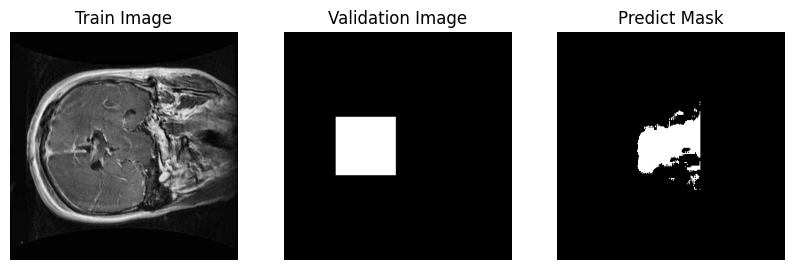

In [66]:
train_image_path = images_path_train_list[0]  # Ảnh đầu tiên trong tập train
train_mask_path = mask_path_train_list[0]  # Ảnh đầu tiên trong tập train
predict(train_image_path, train_mask_path, 256, 256)